# DCNN Single Output Feature Engineered
This model takes the 150,000 rows of acoustic data, and takes the mean, standard deviation etc. of every 128 datapoints (granularity=128) to make our features. Then train a WaveNet-like dialated causal convolutional neural network on these features to predict the time remaining before a lab earthquake.

## Import python modules

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from threading import Thread

import os
import sys
import glob
import random
print("Imported!")

Imported!


## Set Hyperparameters

In [31]:
total_size = 629_145_480
seg_size = 150_000
bin_size = 2**12 # data comes in bins of 2^12 contiguous rows (ADC with 12-bit resolution)
bins_per_seg = (seg_size + bin_size - 1) // bin_size # ceil(seg_size / bin_size)
case_size = bins_per_seg * bin_size
target_size = 40
granularity = 128
seq_size = seg_size // granularity

epochs = 1 * bins_per_seg # there are bins_per_seg number of shifts
batch_size = 2**2
feature_size = 5
valid_steps = 4
learning_rate = 0.0005

total_cases = total_size // case_size
total_batches = (total_cases + batch_size - 1) // batch_size

withheld_cases = 2**8
withheld_batches = (withheld_cases + batch_size - 1) // batch_size
withheld_size = withheld_cases * case_size
withheld_percent = 100 * withheld_size / total_size

valid_cases = valid_steps * batch_size
valid_batches = (valid_cases + batch_size - 1) // batch_size
valid_size = valid_cases * case_size
valid_percent = 100 * valid_size / total_size

train_size = total_size - valid_size - withheld_size
train_cases = total_cases - valid_cases - withheld_cases
train_batches = (train_cases + batch_size - 1) // batch_size
train_percent = 100 * train_size / total_size


print("----- Hyperparameters -----")
print("epochs:", epochs)
print("batch_size:", batch_size)
print("feature_size:", feature_size)
print("valid_steps:", valid_steps)
print("learning_rate:", learning_rate)
print("---------------------------")
print("seg_size:", seg_size)
print("bin_size:", bin_size)
print("bins_per_seg:", bins_per_seg)
print("case_size:", case_size)
print("target_size:", target_size)
print("granularity:", granularity)
print("seq_size:", seq_size)
print("total_cases:", total_cases)
print("total_batches:", total_batches)
print("withheld_cases:", withheld_cases)
print("withheld_batches:", withheld_batches)
print("valid_cases:", valid_cases)
print("valid_batches:", valid_batches)
print("train_cases:", train_cases)
print("train_batches:", train_batches)
print("---------------------------")
print("total_size:       {0:9d}".format(total_size))
print("withheld_size:    {0:9d}".format(withheld_size))
print("train_size:       {0:9d}".format(train_size))
print("valid_size:       {0:9d}".format(valid_size))
print("---------------------------")
print("withheld_percent: {0:8.2f}%".format(withheld_percent))
print("valid_percent:    {0:8.2f}%".format(valid_percent))
print("train_percent:    {0:8.2f}%".format(train_percent))
print("---------------------------")

----- Hyperparameters -----
epochs: 37
batch_size: 4
feature_size: 5
valid_steps: 4
learning_rate: 0.0005
---------------------------
seg_size: 150000
bin_size: 4096
bins_per_seg: 37
case_size: 151552
target_size: 40
granularity: 128
seq_size: 1171
total_cases: 4151
total_batches: 1038
withheld_cases: 256
withheld_batches: 64
valid_cases: 16
valid_batches: 4
train_cases: 3879
train_batches: 970
---------------------------
total_size:       629145480
withheld_size:     38797312
train_size:       587923336
valid_size:         2424832
---------------------------
withheld_percent:     6.17%
valid_percent:        0.39%
train_percent:       93.45%
---------------------------


## Load data

In [3]:
print("Reading data...")
data = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})[:-withheld_size]
print("Done reading data!")

Reading data...
Done reading data!


## Data Augmentation

In [74]:
# A vector with 1's marking the end of a bin
bin_end = np.zeros((1, bin_size // granularity), dtype=np.float32)
bin_end[0,-1] = 1.0

def create_features(df):
    gran_mean = (df.mean(axis=1) - 4.47) / 1.5
    gran_median = (np.median(np.abs(df), axis=1) - 4.5) / 1.5
    gran_std = (df.std(axis=1) - 4.26) / 9.7
    gran_max = (df.max(axis=1) - 13.83) / 19.0
    gran_min = (df.min(axis=1) + 4.83) / 18.6
    return np.c_[gran_mean, gran_median, gran_std, gran_max, gran_min]

def augment_data(df, create_method):
    full_gran = df[:granularity*(seq_size-1)]
    full_gran = full_gran.reshape(seq_size-1, -1)
    full_gran = create_method(full_gran)
    remainder_gran = df[granularity*(seq_size-1):]
    remainder_gran = np.expand_dims(remainder_gran, axis=0)
    remainder_gran = create_method(remainder_gran)
    return np.concatenate((full_gran, remainder_gran), axis=0)

def batch_gen(validation=False):
    samples = np.zeros((batch_size, seq_size, feature_size))
    targets = np.zeros((batch_size, 1))
    while True:
        for shift in random.sample(range(bins_per_seg), bins_per_seg):
            batches = valid_batches if validation else train_batches
            cases = valid_cases if validation else train_cases
            case_idxs = random.sample(range(cases), cases)
            for batch in range(batches):
                start_case = batch * batch_size
                end_case = start_case + batch_size

                for i, case in enumerate(case_idxs[start_case:end_case]):
                    start_row = case * case_size + shift * bin_size
                    end_row = start_row + seg_size
                    seg = data[start_row:end_row]
                    samples[i] = augment_data(seg.acoustic_data.values, create_features)
                    targets[i] = seg.tail(1).time_to_failure.values
                yield samples, targets

train = batch_gen()
valid = batch_gen(validation=True)

## Data visualization

## Define Model

In [71]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from time import time

cb = [ModelCheckpoint("dcnn-model.hdf5", monitor='val_loss', save_weights_only=False, period=3)]
if True:
    cb += [TensorBoard(log_dir="logs/{}".format(time()))]

model = Sequential()
model.add(Conv1D(32, 2, activation='relu', dilation_rate=2**0, strides=1, input_shape=(seq_size, feature_size)))
model.add(Conv1D(32, 2, activation='relu', dilation_rate=2**1, strides=1, input_shape=(None, 32))) 
model.add(Conv1D(32, 2, activation='relu', dilation_rate=2**0, strides=1, input_shape=(None, 32))) 
model.add(Conv1D(64, 2, activation='relu', dilation_rate=2**1, strides=1, input_shape=(None, 32)))   
model.add(Conv1D(64, 2, activation='relu', dilation_rate=2**2, strides=1, input_shape=(None, 64))) 
model.add(Conv1D(128, 2, activation='relu', dilation_rate=2**3, strides=1, input_shape=(None, 64))) 
model.add(Conv1D(128, 2, activation='relu', dilation_rate=2**4, strides=1, input_shape=(None, 128))) 
model.add(Conv1D(256, 2, activation='relu', dilation_rate=2**5, strides=1, input_shape=(None, 128))) 
model.add(Conv1D(256, 2, activation='relu', dilation_rate=2**6, strides=1, input_shape=(None, 256)))
model.add(Conv1D(256, 3, activation='relu', dilation_rate=2**7, strides=1, input_shape=(None, 256))) 
model.add(Conv1D(256, 3, activation='relu', dilation_rate=2**7*3, strides=1, input_shape=(None, 256))) 
# model.add(MaxPooling1D(44, strides=16, padding='same'))
model.add(GlobalAveragePooling1D())
# model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.summary()

# Compile and fit model
model.compile(optimizer=adam(lr=learning_rate), loss="mae")

history = model.fit_generator(train,
                              steps_per_epoch=train_batches,
                              epochs=epochs,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid,
                              validation_steps=valid_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_152 (Conv1D)          (None, 1170, 32)          352       
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 1168, 32)          2080      
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 1167, 32)          2080      
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 1165, 64)          4160      
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 1161, 64)          8256      
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 1153, 128)         16512     
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 1137, 128)         32896     
__________

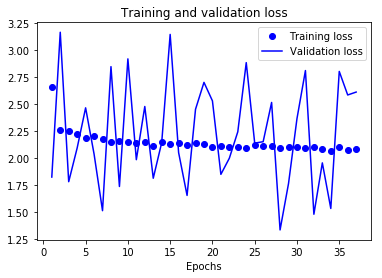

In [72]:
%matplotlib inline
# Visualize accuracies
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1

    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [76]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(submission.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv', dtype={'acoustic_data': np.float32})
    x = augment_data(seg.acoustic_data.values, create_features)
    predict = model.predict(np.expand_dims(x, 0))
    print('\r', i, seg_id, submission.shape[0], predict[0,0], end = '')
    submission.time_to_failure[i] = predict

submission.head()

# Save
submission.to_csv('dcnn-single-output-submission.csv')


 2623 seg_ffe7cc 2624 9.869946142 seg_14d1d3 2624 5.7071223seg_151368 2624 10.019122645 seg_41be18 2624 8.9403305 2624 4.0408612624 2.5328674 2624 10.257059seg_8328f5 2624 6.8623343 seg_c9f80a 2624 3.8082693